In [1]:
import sys
import os
import subprocess
import tarfile
import shutil

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
from Bio import motifs

import boda
from boda.generator.parameters import StraightThroughParameters
from boda.generator import FastSeqProp
from boda.generator.plot_tools import matrix_to_dms, ppm_to_IC, ppm_to_pwm
from boda.model.mpra_basset import MPRA_Basset
from boda.common import constants, utils

boda_src = os.path.join( os.path.dirname( os.path.dirname( os.getcwd() ) ), 'src' )
sys.path.insert(0, boda_src)

from main import unpack_artifact, model_fn
from pymeme import streme, parse_streme_output

In [2]:
def align_to_alphabet(in_tensor, in_alphabet, out_alphabet=constants.STANDARD_NT):
    permuted_idxs = []
    for nt in out_alphabet:
        permuted_idxs.append(in_alphabet.index(nt))
    permutation_idxs = torch.LongTensor(permuted_idxs)
    out_tensor = in_tensor[permutation_idxs, :]
    return out_tensor

def reverse_complement(in_tensor, alphabet=constants.STANDARD_NT):
    rc_dict = {'A':'T', 'G':'C', 'T':'A', 'C':'G'}
    reversed_alphabet = [rc_dict[nt] for nt in alphabet]
    out_tensor = align_to_alphabet(in_tensor, in_alphabet=alphabet,  out_alphabet=reversed_alphabet)
    out_tensor = torch.flip(out_tensor, dims=[1])
    return out_tensor

def show_streme_motifs(parsed_output):
    motif_dict = parsed_output['motif_results']
    results_alphabet = parsed_output['meta_data']['alphabet']
    for motif_idx in range(len(motif_dict)):
        motif_ppm = torch.tensor((motif_dict[motif_idx]['ppm']))
        motif_ppm = align_to_alphabet(motif_ppm, in_alphabet=results_alphabet)
        motif_ppm_rc = reverse_complement(motif_ppm)
        print(motif_dict[motif_idx]['summary'])
        matrix_to_dms(ppm_to_IC(motif_ppm), y_max=2)
        plt.show()
        matrix_to_dms(ppm_to_IC(motif_ppm_rc), y_max=2)
        plt.show()
        
def fasta_to_input_tensor(file_name, left_flank, right_flank):
    fasta_dict = {}
    with open(file_name, 'r') as f:
        for line in f:
            line_str = str(line)
            if line_str[0] == '>':
                my_id = line_str.lstrip('>').rstrip('\n')
                fasta_dict[my_id] = ''
            else:
                fasta_dict[my_id] += line_str.rstrip('\n')
    seq_tensors = []
    for sequence in list(fasta_dict.values()):
        seq_tensors.append(utils.dna2tensor(sequence))
    sequences = torch.stack(seq_tensors, dim=0)
    pieces = [left_flank.repeat(seq_tensor.shape[0], 1, 1), sequences,  right_flank.repeat(seq_tensor.shape[0], 1, 1)]
    return torch.cat(pieces, axis=-1)

In [158]:
#----------------------- HPO model -----------------------
# if os.path.isdir('./artifacts'):
#     shutil.rmtree('./artifacts')
# hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20210623_102310__205717.tar.gz'
# unpack_artifact(hpo_rec)

model_dir = './artifacts'
hpo_model = model_fn(model_dir)
hpo_model.eval()

Loaded model from 20210623_102310 in eval mode


BassetBranched(
  (pad1): ConstantPad1d(padding=(9, 9), value=0.0)
  (conv1): Conv1dNorm(
    (conv): Conv1d(4, 300, kernel_size=(19,), stride=(1,))
    (bn_layer): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pad2): ConstantPad1d(padding=(5, 5), value=0.0)
  (conv2): Conv1dNorm(
    (conv): Conv1d(300, 200, kernel_size=(11,), stride=(1,))
    (bn_layer): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pad3): ConstantPad1d(padding=(3, 3), value=0.0)
  (conv3): Conv1dNorm(
    (conv): Conv1d(200, 200, kernel_size=(7,), stride=(1,))
    (bn_layer): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pad4): ConstantPad1d(padding=(1, 1), value=0.0)
  (maxpool_3): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (maxpool_4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (linear1): LinearNorm(
    (linear): Linear(in

In [3]:
#----------------------- Artisanal model -----------------------
# ! gsutil cp gs://syrgoth/checkpoints/manual_checkpoint_multioutput_lasthidden250_L1.ckpt ./

artisan_model = MPRA_Basset(extra_hidden_size = 250)
checkpoint = torch.load('manual_checkpoint_multioutput_lasthidden250_L1.ckpt')
artisan_model.load_state_dict(checkpoint['state_dict'])
artisan_model.eval()

MPRA_Basset(
  (criterion): MSELoss()
  (last_activation): Tanh()
  (basset_net): Basset(
    (pad1): ConstantPad1d(padding=(9, 9), value=0.0)
    (conv1): Conv1dNorm(
      (conv): Conv1d(4, 300, kernel_size=(19,), stride=(1,))
      (bn_layer): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (pad2): ConstantPad1d(padding=(5, 5), value=0.0)
    (conv2): Conv1dNorm(
      (conv): Conv1d(300, 200, kernel_size=(11,), stride=(1,))
      (bn_layer): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (pad3): ConstantPad1d(padding=(3, 3), value=0.0)
    (conv3): Conv1dNorm(
      (conv): Conv1d(200, 200, kernel_size=(7,), stride=(1,))
      (bn_layer): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (pad4): ConstantPad1d(padding=(1, 1), value=0.0)
    (maxpool_3): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (maxpool_4): MaxPool1d(ker

In [4]:
left_flank = boda.common.utils.dna2tensor(constants.MPRA_UPSTREAM[-200:]).unsqueeze(0)
right_flank = boda.common.utils.dna2tensor(constants.MPRA_DOWNSTREAM[:200] ).unsqueeze(0)

### Comparing entropy distributions between Affine and No-Affine

In [5]:
def castro_reward(x):
    return torch.exp(-x) - x - 1

def basic_reward(x):
    return x

def k562_score(x):
    return -castro_reward(x[:,0]) + 0.5 * (castro_reward( x[:,1]) + castro_reward( x[:,2]))
# def k562_score(x):
#     return x[:,0] - torch.mean(x[:,1:], axis=1) 
def k562_specific(x):
    scores = k562_score(x)
    return torch.mean(-scores)

def hepg2_score(x):
    return -castro_reward(x[:,1]) + 0.5 * (castro_reward( x[:,2]) + castro_reward( x[:,0]))
# def hepg2_score(x):
#     return x[:,1] - torch.mean(x[:, np.r_[0,2]], axis=1)
def hepg2_specific(x):
    scores = hepg2_score(x)
    return torch.mean(- scores)

class mpra_energy(nn.Module):
    def __init__(self,
                 predictor,
                 loss_fn,
                 **kwrags):
        super().__init__()
        self.predictor = predictor
        self.loss_fn = loss_fn

        try: self.predictor.eval()
        except: pass
               
    def forward(self, x):
        preds = self.predictor(x)
        return self.loss_fn(preds)

Steps: 100%|██████████| 300/300 [00:16<00:00, 18.42it/s, Loss=-6.16, LR=1e-6]   


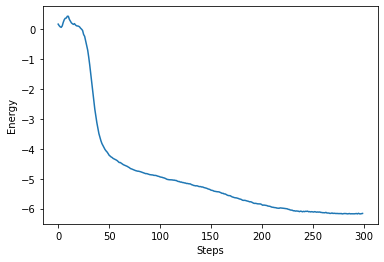

Steps: 100%|██████████| 300/300 [00:15<00:00, 18.83it/s, Loss=-6.67, LR=1e-6]    


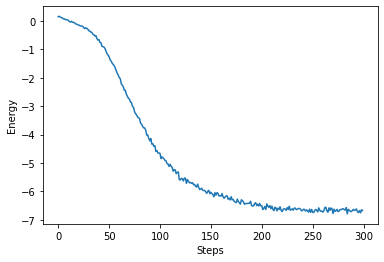

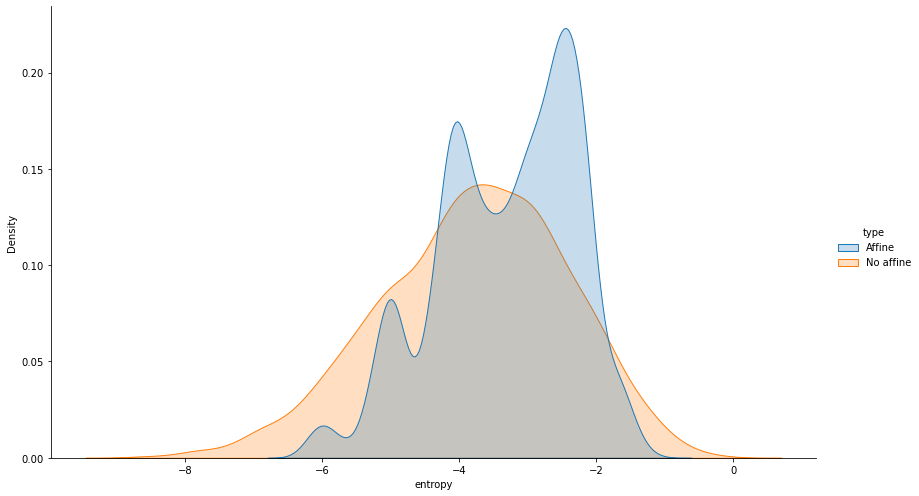

In [11]:
batch_size = 50
sample_takes = 10
n_samples = 10
num_steps = 300
scheduler = True

loss_fn = hepg2_specific
model = artisan_model #hpo_model or artisan_model

energy = mpra_energy(predictor=model,
                     loss_fn=loss_fn)

#--------------------- Affine ------------------------
theta_ini = torch.randn(batch_size, 4, 200)
params = StraightThroughParameters(data=theta_ini,
                                   left_flank=left_flank,
                                   right_flank=right_flank,
                                   n_samples=n_samples,
                                   affine=True)
generator = FastSeqProp(energy_fn=energy,
                        params=params)
generator.cuda()
generator.run(steps=num_steps,
              learning_rate=0.5,
              step_print=20,
              lr_scheduler=scheduler)

entropies_affine = []
for i in range(sample_takes):
    preds = energy.predictor(params())
    entropies_affine += list(boda.graph.utils.shannon_entropy(preds).detach().log().cpu().numpy())

#--------------------- No Affine ------------------------
theta_ini = torch.randn(batch_size, 4, 200)
params = StraightThroughParameters(data=theta_ini,
                                   left_flank=left_flank,
                                   right_flank=right_flank,
                                   n_samples=n_samples,
                                   affine=False)
generator = FastSeqProp(energy_fn=energy,
                        params=params)
generator.cuda()
generator.run(steps=num_steps,
              learning_rate=0.05,
              step_print=20,
              lr_scheduler=scheduler)

entropies_no_affine = []
for i in range(sample_takes):
    preds = energy.predictor(params())
    entropies_no_affine += list(boda.graph.utils.shannon_entropy(preds).detach().log().cpu().numpy())

df_1 = pd.DataFrame(entropies_affine, columns=['entropy'])
df_1['type'] = 'Affine'
df_2 = pd.DataFrame(entropies_no_affine, columns=['entropy'])
df_2['type'] = 'No affine'
df = pd.concat([df_1, df_2])

sns.displot(data=df, x='entropy', hue='type', kind='kde', fill=True, height=7, aspect=10/6)
#plt.xlim(0, 1.2)
plt.show()

In [13]:
preds.unflatten(0, (n_samples, batch_size)).mean(dim=0)

tensor([[ 8.3332e-01,  7.4405e+00, -3.7081e-01],
        [ 1.8370e+00,  7.2569e+00,  5.5325e-01],
        [ 1.3070e+00,  9.9643e+00, -9.9004e-02],
        [ 9.6322e-01,  7.3939e+00, -4.3970e-01],
        [ 1.0330e+00,  7.0475e+00,  1.4720e-01],
        [ 1.7411e+00,  6.5037e+00,  1.0875e-01],
        [ 1.1488e+00,  7.2544e+00,  4.1877e-01],
        [ 1.3962e+00,  6.7481e+00, -6.9140e-02],
        [ 1.2716e+00,  5.6086e+00,  3.8076e-01],
        [ 1.6185e+00,  7.5200e+00, -1.1575e-01],
        [ 1.4514e+00,  5.7030e+00, -1.2420e-02],
        [ 1.4518e+00,  7.8292e+00,  3.5385e-01],
        [ 6.7308e-01,  7.5493e+00, -2.0388e-01],
        [ 1.6171e+00,  8.7965e+00, -7.7769e-02],
        [ 1.0228e+00,  7.8478e+00,  5.5142e-01],
        [ 1.1109e+00,  6.4779e+00, -3.3372e-03],
        [ 1.2334e+00,  5.8454e+00, -2.5866e-01],
        [ 1.9393e+00,  8.9520e+00,  1.6745e-01],
        [ 1.2768e+00,  6.6483e+00,  1.9464e-01],
        [ 1.7877e+00,  8.3115e+00, -3.5173e-02],
        [ 1.0740e+00

### Generating multiple mini-batches

In [ ]:
%%time
#------------------ Choose settings ------------------
affine_trans = False
num_batches = 20
batch_size = 50
#sample_takes = 10
n_samples = 20
num_steps = 300
scheduler = True
loss_plots = False

loss_fn = k562_specific
model = artisan_model     #hpo_model or artisan_model

#------------------ Optimization run ------------------
energy = mpra_energy(predictor=model,
                     loss_fn=loss_fn)

distributions = []
sequence_samples = []
predictions = []
entropies = []
for iteration in range(num_batches):
    theta_ini = torch.randn(batch_size, 4, 200)
    params = StraightThroughParameters(data=theta_ini,
                                       left_flank=left_flank,
                                       right_flank=right_flank,
                                       n_samples=n_samples,
                                       affine=affine_trans)
    generator = FastSeqProp(energy_fn=energy,
                            params=params)
    generator.cuda()
    generator.run(steps=num_steps,
                  learning_rate=0.5,
                  step_print=20,
                  lr_scheduler=scheduler,
                  create_plot=loss_plots)
       
    samples = params()
    preds = energy.predictor(samples)
    
    distributions.append(params.get_probs().detach().cpu())    
    sequence_samples.append(samples.detach().cpu().unflatten(0, (n_samples, batch_size)))
    predictions.append(preds.detach().cpu().unflatten(0, (n_samples, batch_size)))
    entropies.append(boda.graph.utils.shannon_entropy(preds).detach().cpu().unflatten(0, (n_samples, batch_size)))

entropy_tensor = torch.cat(entropies, dim=1)
prediction_tensor = torch.cat(predictions, dim=1)
sequences_tensor = torch.cat(sequence_samples, dim=1)
distributions_tensor = torch.cat(distributions, dim=0)

In [ ]:
#------------------ Select best sequences ------------------
best_entropy_idxs = torch.argmin(entropy_tensor, dim=0)
best_entropies = []
best_predictions = []
best_sequences = []
for idx, best_idx in enumerate(best_entropy_idxs.tolist()):
    best_entropies.append(entropy_tensor[best_idx, idx])
    best_predictions.append(prediction_tensor[best_idx, idx, :])
    best_sequences.append(sequences_tensor[best_idx, idx, :, 200:400])
    
best_entropies = torch.tensor(best_entropies)
best_predictions = torch.stack(best_predictions, dim=0)
best_sequences = torch.stack(best_sequences, dim=0)

#------------------ Plot entropy distribution ------------------
sns.displot(data=best_entropies, kind='kde', fill=True, height=5, aspect=10/6)
plt.xlim(0, 1)
plt.xlabel('Entropy')
plt.show()

#------------------ Plot activities in 3D ------------------
xdata = best_predictions[:,0].cpu().detach().numpy()
ydata = best_predictions[:,1].cpu().detach().numpy()
zdata = best_predictions[:,2].cpu().detach().numpy()

fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
xAxisLine = ((-2, 8), (0, 0), (0,0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
yAxisLine = ((0, 0), (-2, 8), (0,0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
zAxisLine = ((0, 0), (0,0), (-2, 8))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')

ax.scatter3D(xdata, ydata, zdata, c='blue')
ax.set_xlabel("K562")
ax.set_ylabel("HepG2")
ax.set_zlabel("SKNSH")
ax.view_init(15, -45)
plt.show()

In [ ]:
file_name = 'k562_1000dist_castro.txt' + 'v2'
utils.batch2fasta(best_sequences, file_name)

## Analysis with STREME

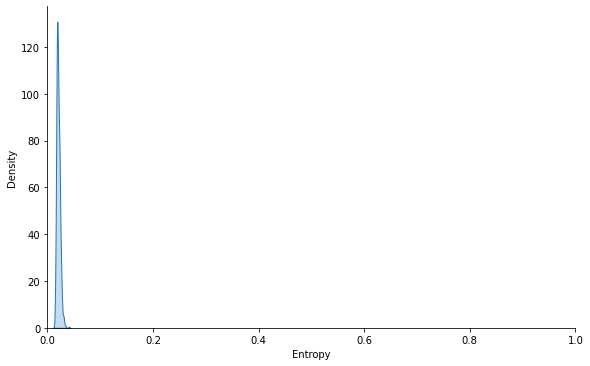

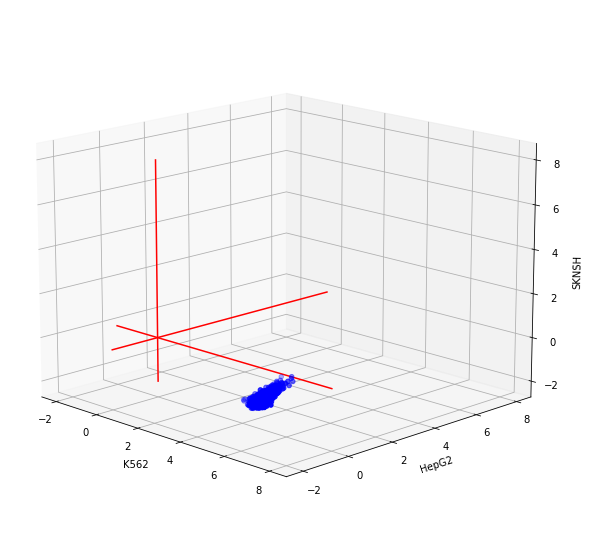

In [50]:
file_name = 'k562_1000dist_castro.txt'
model = artisan_model

model.cuda()
model.eval()

fasta_as_tensor = fasta_to_input_tensor(file_name, left_flank, right_flank)
preds = model(fasta_as_tensor.cuda()).cpu()
entropies = boda.graph.utils.shannon_entropy(preds).detach()

#------------------ Plot entropy distribution ------------------
sns.displot(data=entropies, kind='kde', fill=True, height=5, aspect=10/6)
plt.xlim(0, 1)
plt.xlabel('Entropy')
plt.show()

#------------------ Plot activities in 3D ------------------
xdata = preds[:,0].cpu().detach().numpy()
ydata = preds[:,1].cpu().detach().numpy()
zdata = preds[:,2].cpu().detach().numpy()

fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
xAxisLine = ((-2, 8), (0, 0), (0,0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
yAxisLine = ((0, 0), (-2, 8), (0,0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
zAxisLine = ((0, 0), (0,0), (-2, 8))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')

ax.scatter3D(xdata, ydata, zdata, c='blue')
ax.set_xlabel("K562")
ax.set_ylabel("HepG2")
ax.set_zlabel("SKNSH")
ax.view_init(15, -45)
plt.show()

In [6]:
file_name = 'k562_1000dist_castro.txt'
test_seq_file = '/home/ubuntu/boda2/analysis/RC04_FastSeqProp_MotifPenalty/' + file_name

streme_results = streme(test_seq_file)
for i, line in enumerate(streme_results['output'].decode("utf-8").split('\n')):
    print(line)                                                 

********************************************************************************
STREME - Sensitive, Thorough, Rapid, Enriched Motif Elicitation
********************************************************************************
MEME version 5.4.0 (Release date: Sat Aug 21 19:23:23 2021 -0700)

For further information on how to interpret these results please access https://meme-suite.org/meme.
To get a copy of the MEME Suite software please access https://meme-suite.org.

********************************************************************************


********************************************************************************
REFERENCE
********************************************************************************
If you use this program in your research, please cite:

Timothy L. Bailey,
"STREME: accurate and versatile sequence motif discovery",
Bioinformatics, Mar. 24, 2021.
********************************************************************************


ALPHABET= ACGT

strands

In [7]:
parsed_output = parse_streme_output(streme_results['output'])
parsed_output

{'meta_data': {'alphabet': ['A', 'C', 'G', 'T'],
  'frequencies': {'A': 0.253, 'C': 0.247, 'G': 0.247, 'T': 0.253}},
 'motif_results': [{'tag': 'AGAGATAAGGHG',
   'summary': {'alength': 4, 'w': 12, 'nsites': 973, 'E': 1.4e-35},
   'ppm': array([[6.93660e-01, 5.95190e-02, 8.69458e-01, 4.40000e-05, 9.97490e-01,
           1.23500e-03, 9.97490e-01, 9.92726e-01, 2.42600e-03, 1.75492e-01,
           3.07017e-01, 1.56509e-01],
          [8.83300e-02, 2.56921e-01, 2.73370e-02, 4.20000e-05, 4.20000e-05,
           4.20000e-05, 4.20000e-05, 4.20000e-05, 1.73160e-02, 4.15120e-02,
           2.13047e-01, 7.20140e-02],
          [7.99750e-02, 5.94702e-01, 2.42400e-03, 9.99871e-01, 1.23300e-03,
           4.20000e-05, 1.23300e-03, 1.23300e-03, 9.79024e-01, 7.61507e-01,
           1.06049e-01, 5.51944e-01],
          [1.38035e-01, 8.88570e-02, 1.00781e-01, 4.40000e-05, 1.23400e-03,
           9.98680e-01, 1.23400e-03, 5.99800e-03, 1.23400e-03, 2.14890e-02,
           3.73887e-01, 2.19533e-01]])},
  

{'alength': 4, 'w': 12, 'nsites': 973, 'E': 1.4e-35}


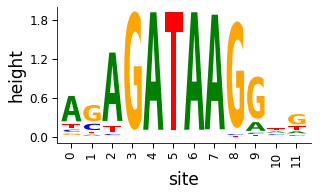

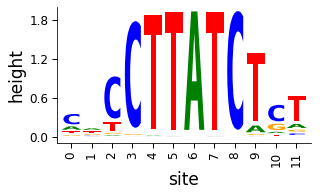

{'alength': 4, 'w': 10, 'nsites': 676, 'E': 4.5e-21}


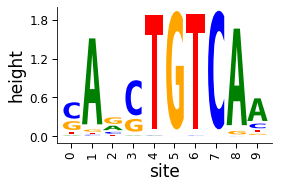

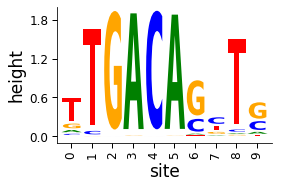

{'alength': 4, 'w': 10, 'nsites': 717, 'E': 8.2e-09}


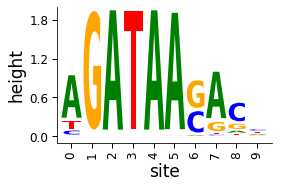

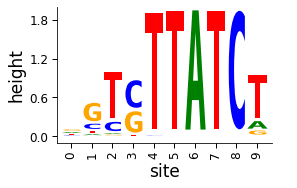

{'alength': 4, 'w': 10, 'nsites': 367, 'E': 6.7e-06}


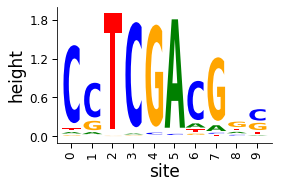

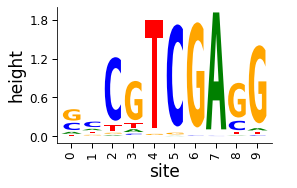

{'alength': 4, 'w': 8, 'nsites': 338, 'E': 0.0063}


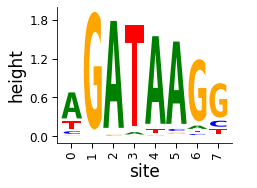

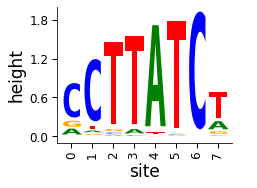

{'alength': 4, 'w': 10, 'nsites': 333, 'E': 0.1}


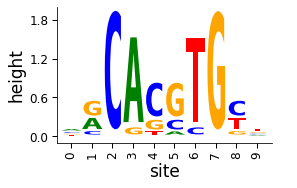

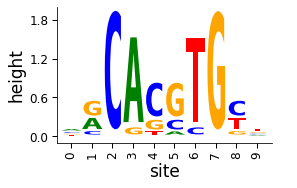

{'alength': 4, 'w': 10, 'nsites': 333, 'E': 0.47}


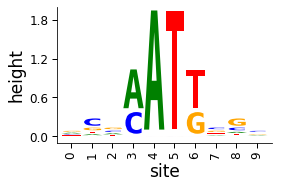

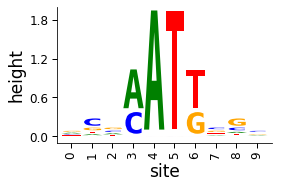

{'alength': 4, 'w': 8, 'nsites': 157, 'E': 1.7}


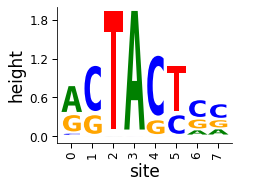

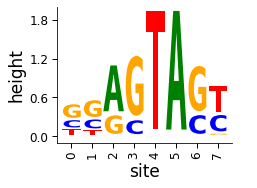

{'alength': 4, 'w': 8, 'nsites': 113, 'E': 3.7}


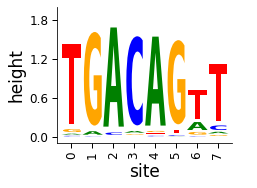

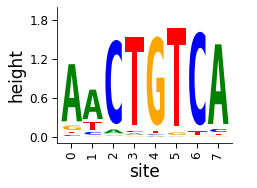

{'alength': 4, 'w': 9, 'nsites': 67, 'E': 5}


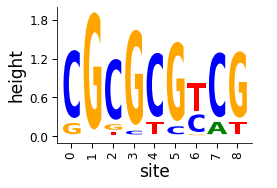

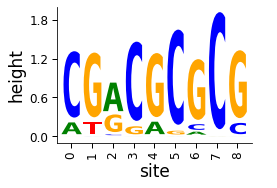

In [5]:
show_streme_motifs(parsed_output)

# Motif penalization

In [56]:
class energy_with_penalty(nn.Module):
    def __init__(self,
                 predictor,
                 loss_fn,
                 ppm,
                 score_pct,
                 streme_alphabet=['A', 'C', 'G', 'T'],
                 streme_background=[0.25,0.25,0.25,0.25],                 
                 **kwrags):
        super().__init__()
        self.predictor = predictor
        self.loss_fn = loss_fn
        self.score_pct = score_pct
        
        self.ppm = align_to_alphabet(ppm, in_alphabet=streme_alphabet)    
        self.pwm = ppm_to_pwm(self.ppm, streme_background)
        self.pwm_rc = reverse_complement(self.pwm)      
        
        self.score_threshold = self.get_score_threshold()
        self.register_buffer('filters', torch.stack([self.pwm, self.pwm_rc], dim=0))
        
        try: self.predictor.eval()
        except: pass
               
    def forward(self, x):
        motif_scores = F.conv1d(x, self.filters)
        mask = torch.ge(motif_scores, self.score_threshold)
        masked_scores = torch.masked_select(motif_scores, mask)
        score_penalty = masked_scores.sum(dim=-1).mean() / x.shape[0]  #* abs(self.score_threshold))
        preds = self.predictor(x)
        return self.loss_fn(preds) + score_penalty
    
    def get_score_threshold(self):
        max_score = torch.max(self.pwm, dim=0)[0].sum()
        min_score = torch.min(self.pwm, dim=0)[0].sum()
        return self.score_pct * max_score
    
    
class energy_simpler_penalty(nn.Module):
    def __init__(self,
                 predictor,
                 loss_fn,
                 penalty_motifs,
                 **kwrags):
        super().__init__()
        self.predictor = predictor
        self.loss_fn = loss_fn
        self.penalty_motifs = penalty_motifs
        
        self.get_filters()
        
        try: self.predictor.eval()
        except: pass
               
    def forward(self, x):
        motif_scans = F.conv1d(x, self.filters)
        mask = torch.ge(motif_scans, 4)
        motif_penalty = torch.masked_select(motif_scans, mask).sum(dim=-1).mean() / x.shape[0]  
        preds = self.predictor(x)
        return self.loss_fn(preds) + motif_penalty
    
    def get_filters(self):
        filters = [utils.dna2tensor(motif) for motif in self.penalty_motifs]
        filters = torch.stack(filters, dim=0)
        self.register_buffer('filters', filters)

In [15]:
torch.stack([top_ppm], dim=0).shape, [1,2]+[3,4]

(torch.Size([1, 4, 12]), [1, 2, 3, 4])

### Medium penalty

In [57]:
%%time
# file_name = 'k562_1000dist_castro.txt'
# test_seq_file = '/home/ubuntu/boda2/analysis/RC04_FastSeqProp_MotifPenalty/' + file_name
# streme_results = streme(test_seq_file)
# parsed_output = parse_streme_output(streme_results['output'])

#------------------ Choose settings ------------------
score_pct = 0.25

affine_trans = False
num_batches = 20
batch_size = 50
#sample_takes = 10
n_samples = 20
num_steps = 300
scheduler = True
loss_plots = False

loss_fn = k562_specific
model = artisan_model     #hpo_model or artisan_model

#-- Streme outputs --
result_dict = parsed_output

top_ppm = torch.Tensor((result_dict['motif_results'][0]['ppm']))#[:,3:8]
results_alphabet = result_dict['meta_data']['alphabet']
results_background = [result_dict['meta_data']['frequencies'][nt] for nt in constants.STANDARD_NT]

#------------------ Optimization run ------------------
energy = energy_with_penalty(predictor=model,
                             loss_fn=loss_fn,
                             ppm=top_ppm,
                             score_pct=score_pct,
                             streme_alphabet=results_alphabet,
                             streme_background=results_background)

# undesired_motifs = ['GATAA',
#                     'TTATC']
# energy = energy_simpler_penalty(predictor=model,
#                                 loss_fn=loss_fn,
#                                 penalty_motifs=undesired_motifs)

# distributions = []
# sequence_samples = []
# predictions = []
# entropies = []
# for iteration in range(num_batches):
#     theta_ini = torch.randn(batch_size, 4, 200)
#     params = StraightThroughParameters(data=theta_ini,
#                                        left_flank=left_flank,
#                                        right_flank=right_flank,
#                                        n_samples=n_samples,
#                                        affine=affine_trans)
#     generator = FastSeqProp(energy_fn=energy,
#                             params=params)
#     generator.cuda()
#     generator.run(steps=num_steps,
#                   learning_rate=0.5,
#                   step_print=5,
#                   lr_scheduler=scheduler,
#                   create_plot=loss_plots)
       
#     samples = params()
#     preds = energy.predictor(samples)
    
#     distributions.append(params.get_probs().detach().cpu())    
#     sequence_samples.append(samples.detach().cpu().unflatten(0, (n_samples, batch_size)))
#     predictions.append(preds.detach().cpu().unflatten(0, (n_samples, batch_size)))
#     entropies.append(boda.graph.utils.shannon_entropy(preds).detach().cpu().unflatten(0, (n_samples, batch_size)))

# entropy_tensor = torch.cat(entropies, dim=1)
# prediction_tensor = torch.cat(predictions, dim=1)
# sequences_tensor = torch.cat(sequence_samples, dim=1)
# distributions_tensor = torch.cat(distributions, dim=0)

TypeError: 'NoneType' object is not iterable

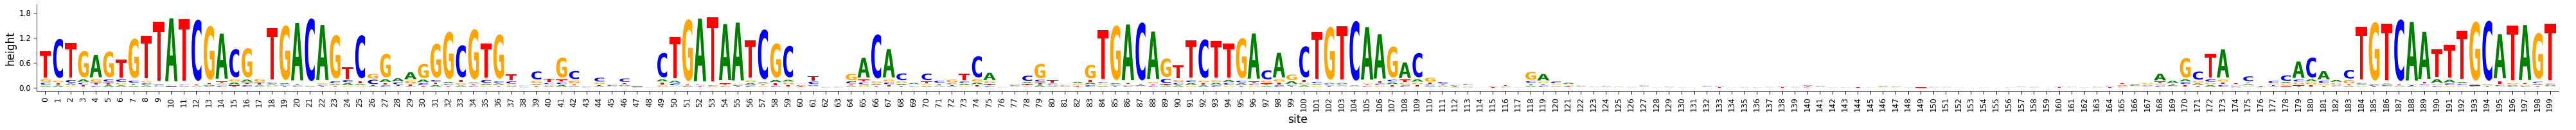

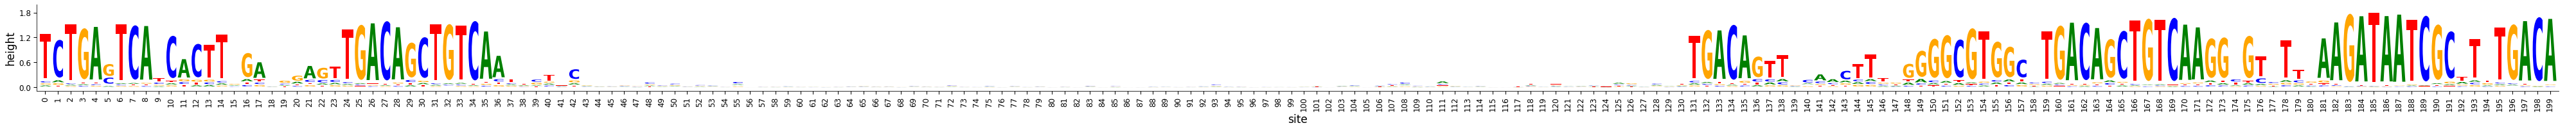

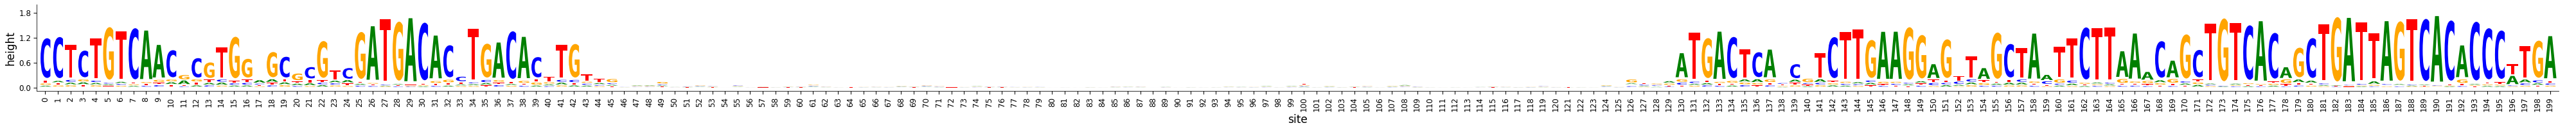

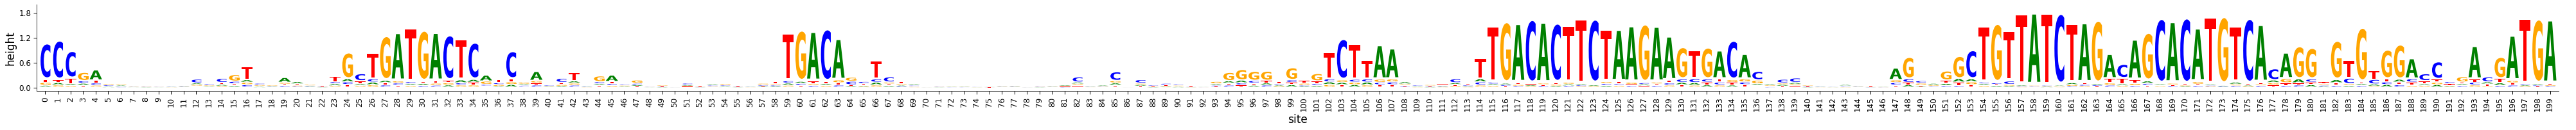

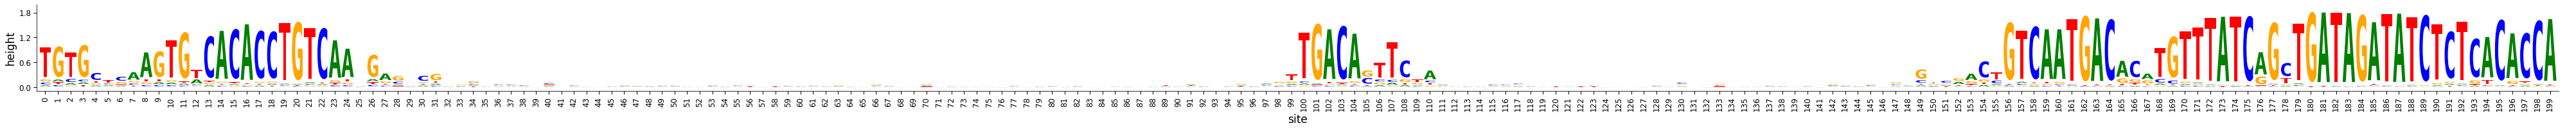

In [328]:
#----- Sanity check -----
for i in range(5):
    distribution = distributions_tensor[i,:,:]
    matrix_to_dms(ppm_to_IC(distribution), y_max=2)
    plt.show()

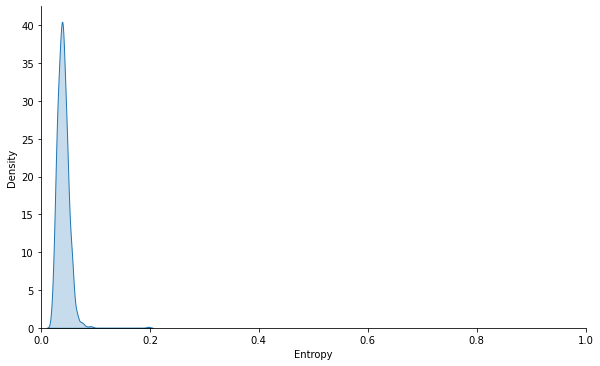

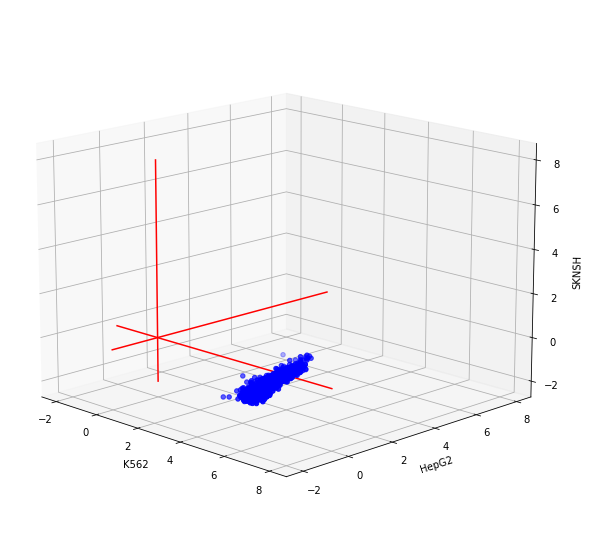

In [329]:
#------------------ Select best sequences ------------------
best_entropy_idxs = torch.argmin(entropy_tensor, dim=0)
best_entropies = []
best_predictions = []
best_sequences = []
for idx, best_idx in enumerate(best_entropy_idxs.tolist()):
    best_entropies.append(entropy_tensor[best_idx, idx])
    best_predictions.append(prediction_tensor[best_idx, idx, :])
    best_sequences.append(sequences_tensor[best_idx, idx, :, 200:400])
    
best_entropies = torch.tensor(best_entropies)
best_predictions = torch.stack(best_predictions, dim=0)
best_sequences = torch.stack(best_sequences, dim=0)

#------------------ Plot entropy distribution ------------------
sns.displot(data=best_entropies, kind='kde', fill=True, height=5, aspect=10/6)
plt.xlim(0, 1)
plt.xlabel('Entropy')
plt.show()

#------------------ Plot activities in 3D ------------------
xdata = best_predictions[:,0].cpu().detach().numpy()
ydata = best_predictions[:,1].cpu().detach().numpy()
zdata = best_predictions[:,2].cpu().detach().numpy()

fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
xAxisLine = ((-2, 8), (0, 0), (0,0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
yAxisLine = ((0, 0), (-2, 8), (0,0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
zAxisLine = ((0, 0), (0,0), (-2, 8))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')

ax.scatter3D(xdata, ydata, zdata, c='blue')
ax.set_xlabel('K562')
ax.set_ylabel('HepG2')
ax.set_zlabel('SKNSH')
ax.view_init(15, -45)
plt.show()

{'alength': 4, 'w': 15, 'nsites': 872, 'E': 1.7e-29}


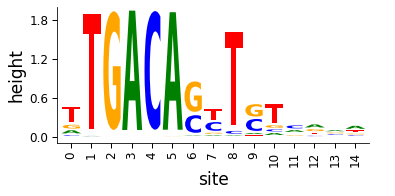

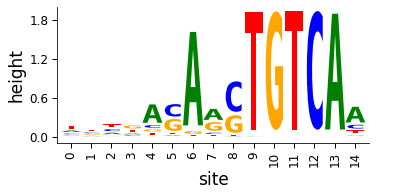

{'alength': 4, 'w': 12, 'nsites': 557, 'E': 1.2e-11}


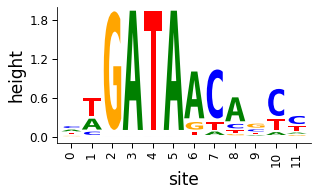

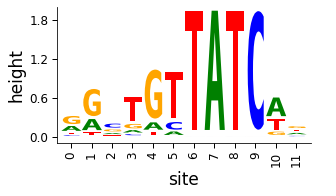

{'alength': 4, 'w': 10, 'nsites': 524, 'E': 3.7e-08}


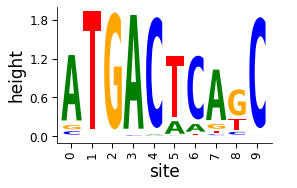

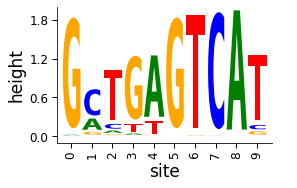

{'alength': 4, 'w': 11, 'nsites': 396, 'E': 0.0096}


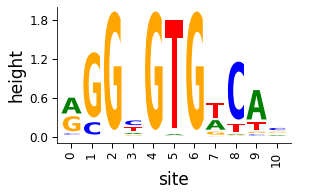

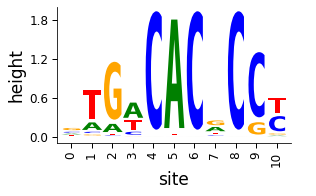

{'alength': 4, 'w': 9, 'nsites': 173, 'E': 0.016}


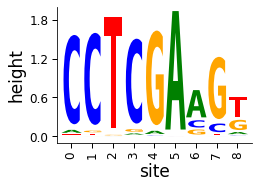

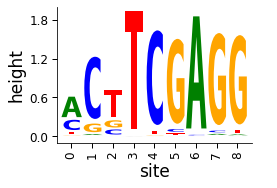

{'alength': 4, 'w': 10, 'nsites': 227, 'E': 0.031}


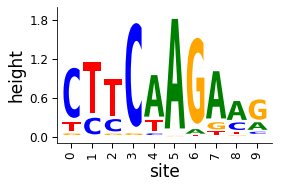

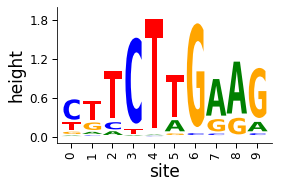

{'alength': 4, 'w': 11, 'nsites': 66, 'E': 0.32}


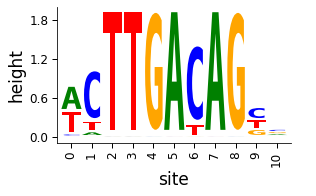

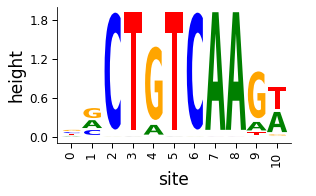

{'alength': 4, 'w': 8, 'nsites': 60, 'E': 0.32}


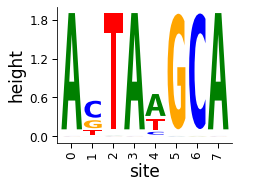

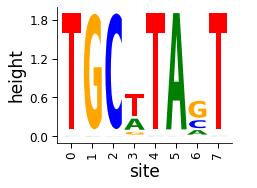

{'alength': 4, 'w': 13, 'nsites': 32, 'E': 1.4}


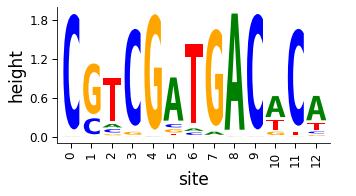

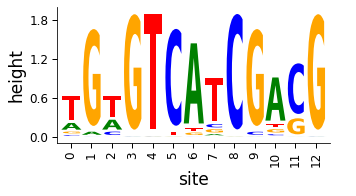

{'alength': 4, 'w': 8, 'nsites': 397, 'E': 2.1}


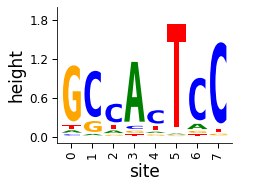

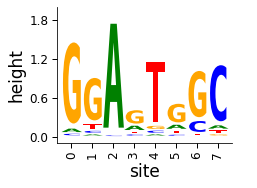

{'alength': 4, 'w': 9, 'nsites': 167, 'E': 3.4}


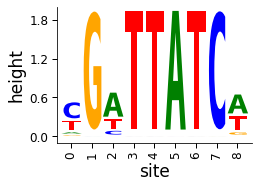

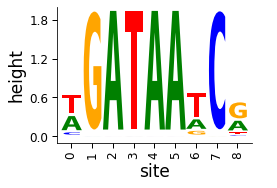

In [330]:
file_name = 'k562_1000dist_castro_penalty.txt'#'test_penalty.txt'
utils.batch2fasta(best_sequences, file_name)
test_seq_file_penalty = '/home/ubuntu/boda2/analysis/RC04_FastSeqProp_MotifPenalty/' + file_name

streme_results_penalty = streme(test_seq_file_penalty)
parsed_output_penalty = parse_streme_output(streme_results_penalty['output'])
show_streme_motifs(parsed_output_penalty)

### Harder penalty

In [331]:
%%time
# file_name = 'k562_1000dist_castro.txt'
# test_seq_file = '/home/ubuntu/boda2/analysis/RC04_FastSeqProp_MotifPenalty/' + file_name
# streme_results = streme(test_seq_file)
# parsed_output = parse_streme_output(streme_results['output'])

#------------------ Choose settings ------------------
score_pct = 0

affine_trans = False
num_batches = 20
batch_size = 50
#sample_takes = 10
n_samples = 20
num_steps = 300
scheduler = True
loss_plots = False

loss_fn = k562_specific
model = artisan_model     #hpo_model or artisan_model

#-- Streme outputs --
result_dict = parsed_output

top_ppm = torch.Tensor((result_dict['motif_results'][0]['ppm']))
results_alphabet = result_dict['meta_data']['alphabet']
results_background = [result_dict['meta_data']['frequencies'][nt] for nt in constants.STANDARD_NT]

#------------------ Optimization run ------------------
energy = energy_with_penalty(predictor=model,
                             loss_fn=loss_fn,
                             ppm=top_ppm,
                             score_pct=score_pct,
                             streme_alphabet=results_alphabet,
                             streme_background=results_background)

# undesired_motifs = ['GATAA',
#                     'TTATC']
# energy = energy_simpler_penalty(predictor=model,
#                                 loss_fn=loss_fn,
#                                 penalty_motifs=undesired_motifs)

distributions = []
sequence_samples = []
predictions = []
entropies = []
for iteration in range(num_batches):
    theta_ini = torch.randn(batch_size, 4, 200)
    params = StraightThroughParameters(data=theta_ini,
                                       left_flank=left_flank,
                                       right_flank=right_flank,
                                       n_samples=n_samples,
                                       affine=affine_trans)
    generator = FastSeqProp(energy_fn=energy,
                            params=params)
    generator.cuda()
    generator.run(steps=num_steps,
                  learning_rate=0.5,
                  step_print=5,
                  lr_scheduler=scheduler,
                  create_plot=loss_plots)
       
    samples = params()
    preds = energy.predictor(samples)
    
    distributions.append(params.get_probs().detach().cpu())    
    sequence_samples.append(samples.detach().cpu().unflatten(0, (n_samples, batch_size)))
    predictions.append(preds.detach().cpu().unflatten(0, (n_samples, batch_size)))
    entropies.append(boda.graph.utils.shannon_entropy(preds).detach().cpu().unflatten(0, (n_samples, batch_size)))

entropy_tensor = torch.cat(entropies, dim=1)
prediction_tensor = torch.cat(predictions, dim=1)
sequences_tensor = torch.cat(sequence_samples, dim=1)
distributions_tensor = torch.cat(distributions, dim=0)

Steps: 100%|██████████| 300/300 [00:30<00:00,  9.87it/s, Loss=-3.97, LR=1e-6]    

CPU times: user 10min 12s, sys: 2.87 s, total: 10min 15s
Wall time: 10min 11s


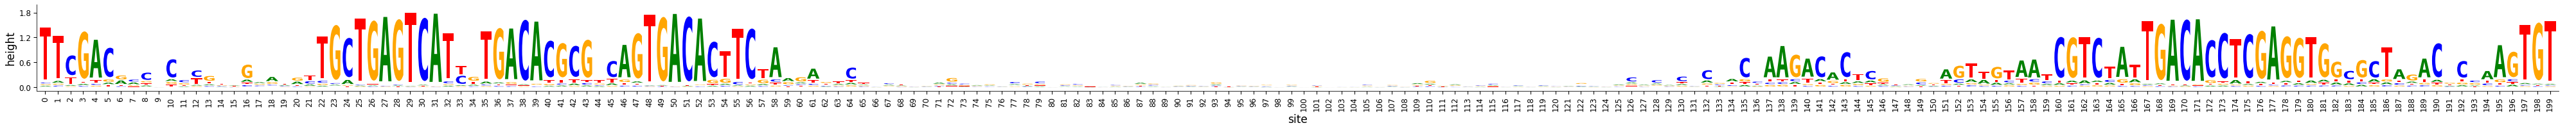

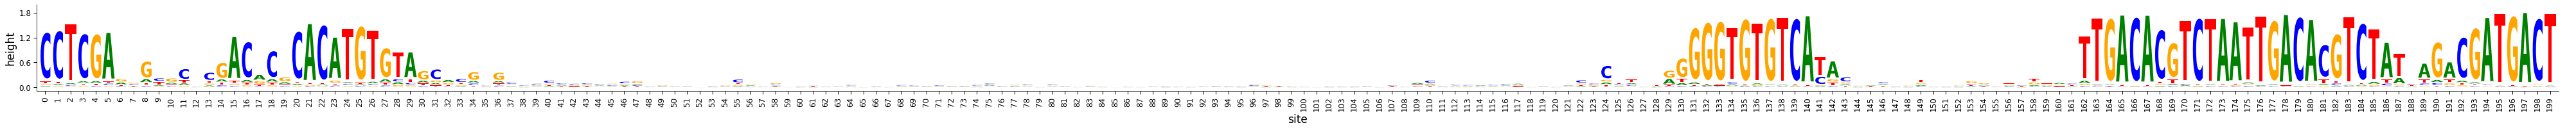

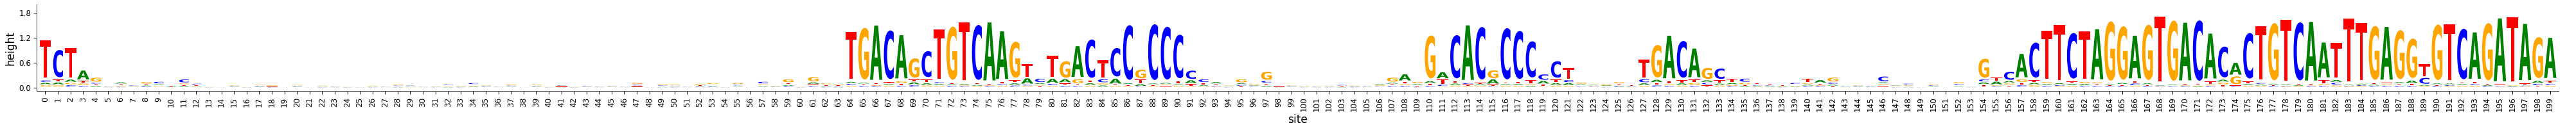

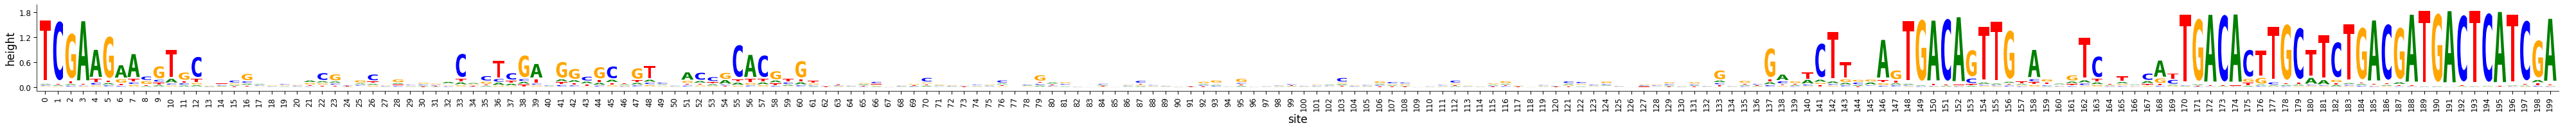

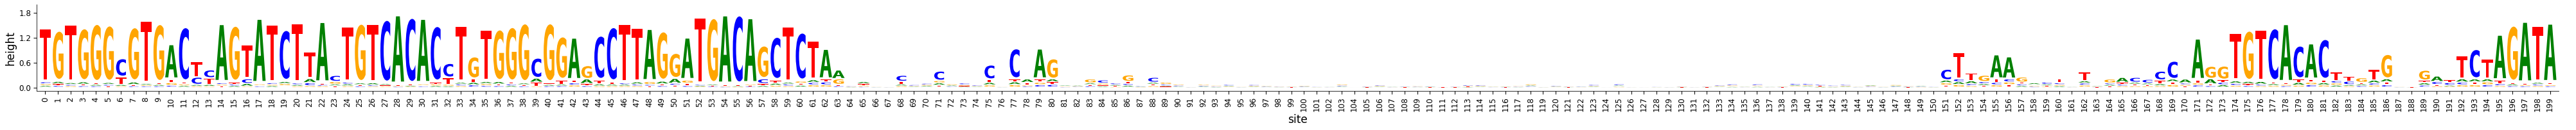

In [336]:
#----- Sanity check -----
for i in range(5):
    distribution = distributions_tensor[i,:,:]
    matrix_to_dms(ppm_to_IC(distribution), y_max=2)
    plt.show()

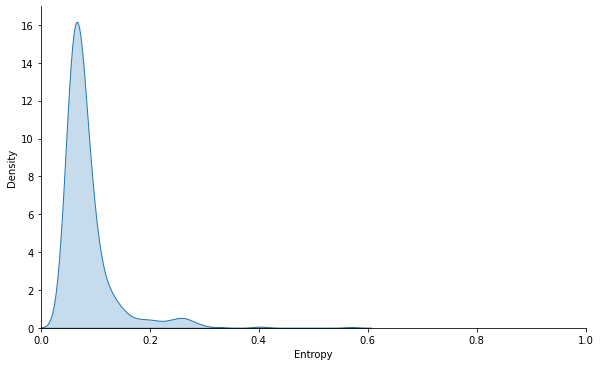

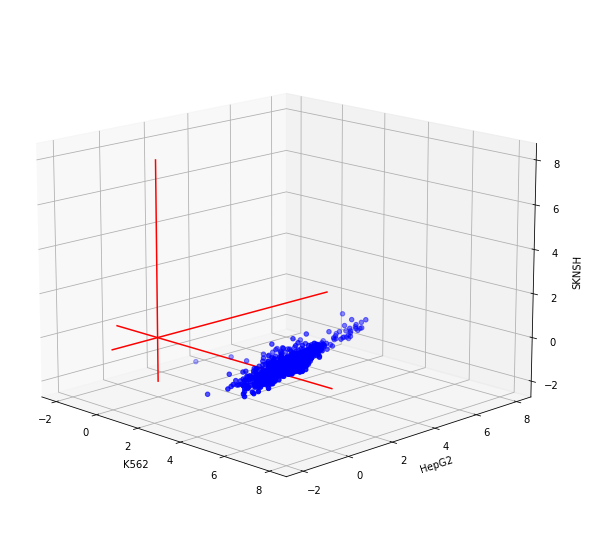

In [333]:
#------------------ Select best sequences ------------------
best_entropy_idxs = torch.argmin(entropy_tensor, dim=0)
best_entropies = []
best_predictions = []
best_sequences = []
for idx, best_idx in enumerate(best_entropy_idxs.tolist()):
    best_entropies.append(entropy_tensor[best_idx, idx])
    best_predictions.append(prediction_tensor[best_idx, idx, :])
    best_sequences.append(sequences_tensor[best_idx, idx, :, 200:400])
    
best_entropies = torch.tensor(best_entropies)
best_predictions = torch.stack(best_predictions, dim=0)
best_sequences = torch.stack(best_sequences, dim=0)

#------------------ Plot entropy distribution ------------------
sns.displot(data=best_entropies, kind='kde', fill=True, height=5, aspect=10/6)
plt.xlim(0, 1)
plt.xlabel('Entropy')
plt.show()

#------------------ Plot activities in 3D ------------------
xdata = best_predictions[:,0].cpu().detach().numpy()
ydata = best_predictions[:,1].cpu().detach().numpy()
zdata = best_predictions[:,2].cpu().detach().numpy()

fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
xAxisLine = ((-2, 8), (0, 0), (0,0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
yAxisLine = ((0, 0), (-2, 8), (0,0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
zAxisLine = ((0, 0), (0,0), (-2, 8))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')

ax.scatter3D(xdata, ydata, zdata, c='blue')
ax.set_xlabel('K562')
ax.set_ylabel('HepG2')
ax.set_zlabel('SKNSH')
ax.view_init(15, -45)
plt.show()

{'alength': 4, 'w': 12, 'nsites': 787, 'E': 9.7e-23}


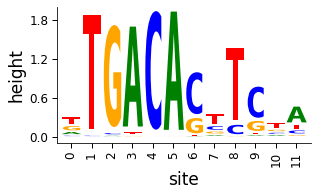

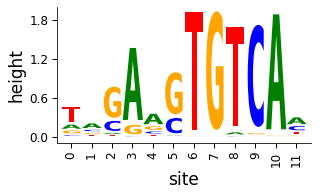

{'alength': 4, 'w': 11, 'nsites': 235, 'E': 3.7e-08}


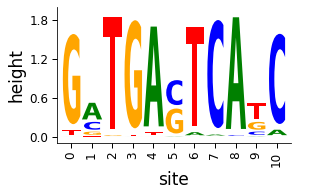

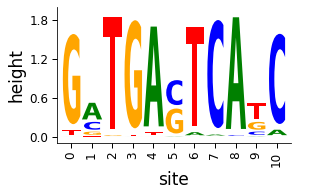

{'alength': 4, 'w': 12, 'nsites': 178, 'E': 1.2e-05}


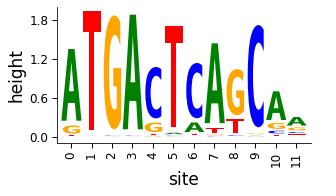

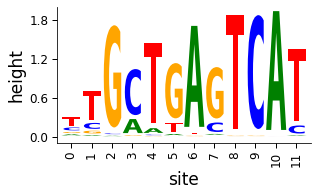

{'alength': 4, 'w': 10, 'nsites': 459, 'E': 0.0016}


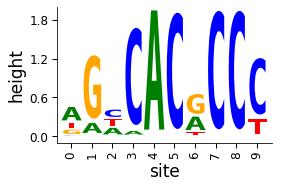

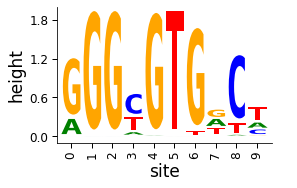

{'alength': 4, 'w': 10, 'nsites': 232, 'E': 0.0066}


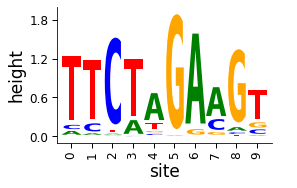

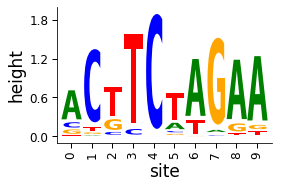

{'alength': 4, 'w': 13, 'nsites': 149, 'E': 0.01}


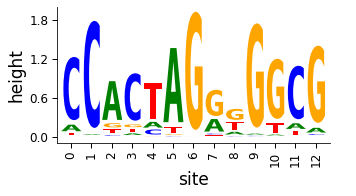

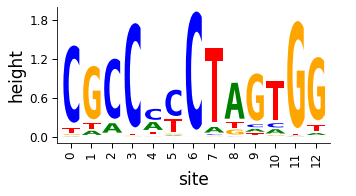

{'alength': 4, 'w': 9, 'nsites': 126, 'E': 0.023}


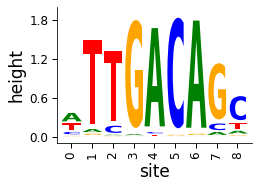

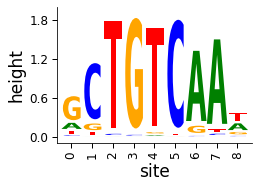

{'alength': 4, 'w': 12, 'nsites': 82, 'E': 0.044}


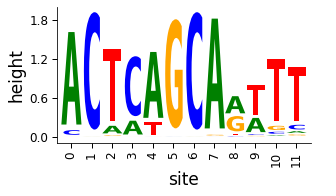

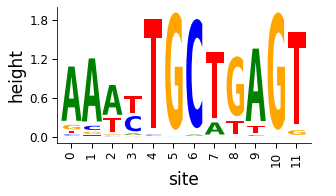

{'alength': 4, 'w': 8, 'nsites': 221, 'E': 0.15}


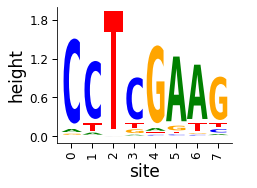

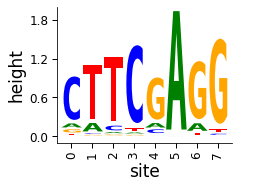

{'alength': 4, 'w': 9, 'nsites': 145, 'E': 0.19}


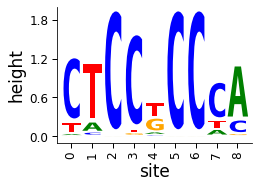

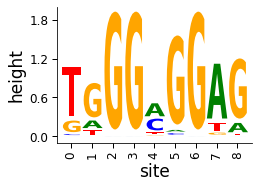

{'alength': 4, 'w': 8, 'nsites': 55, 'E': 0.23}


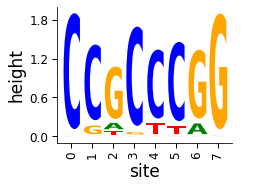

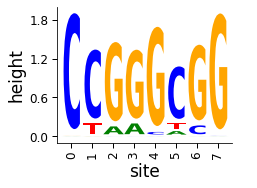

{'alength': 4, 'w': 9, 'nsites': 202, 'E': 0.41}


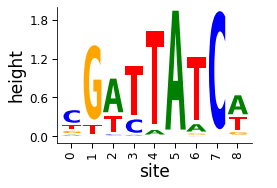

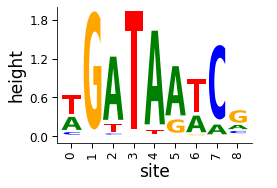

{'alength': 4, 'w': 8, 'nsites': 46, 'E': 0.52}


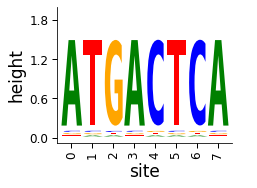

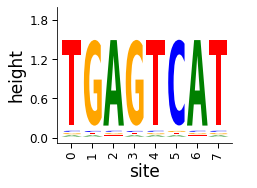

{'alength': 4, 'w': 9, 'nsites': 55, 'E': 5}


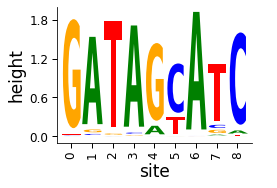

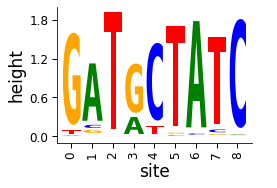

{'alength': 4, 'w': 12, 'nsites': 156, 'E': 8}


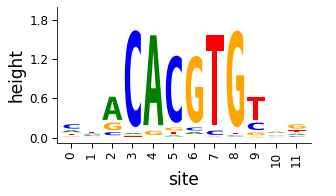

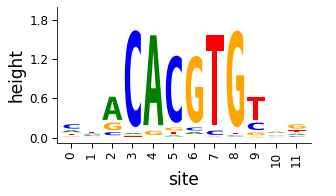

{'alength': 4, 'w': 15, 'nsites': 37, 'E': 8}


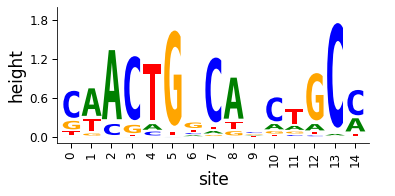

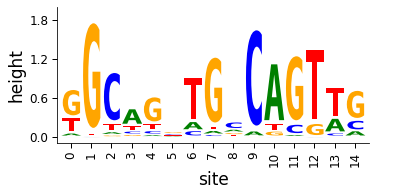

In [335]:
file_name = 'k562_1000dist_castro_HardPenalty.txt'#'test_penalty.txt'
utils.batch2fasta(best_sequences, file_name)
test_seq_file_penalty = '/home/ubuntu/boda2/analysis/RC04_FastSeqProp_MotifPenalty/' + file_name

streme_results_penalty = streme(test_seq_file_penalty)
parsed_output_penalty = parse_streme_output(streme_results_penalty['output'])
show_streme_motifs(parsed_output_penalty)

## Acummulating motif penalties

In [84]:
class energy_multipenalty(nn.Module):
    def __init__(self,
                 predictor,
                 loss_fn,
                 ppms=[],
                 score_pct=0,
                 ppms_alphabet=['A', 'C', 'G', 'T'],
                 backgrounds=None,                 
                 **kwrags):
        super().__init__()
        self.predictor = predictor
        self.loss_fn = loss_fn
        self.score_pct = score_pct
        self.ppms = ppms
        self.ppms_alphabet = ppms_alphabet
        
        self.max_ppm_len = max([ppm.shape[-1] for ppm in self.ppms])
             
        try: self.predictor.eval()
        except: pass
        
        if len(self.ppms) == 0:
            self.penalization_flag = False
            self.backgrounds = backgrounds
            self.filters = None
            self.score_thresholds = None
        else:
            self.penalization_flag = True
            if backgrounds is None:
                self.backgrounds = [ 4*[0.25] for i in range(len(self.ppms))]
            self.filters_and_thresholds()
    
    def filters_and_thresholds(self):        
        pwms = []
        score_thresholds = []
        for ppm, background in zip(self.ppms, self.backgrounds):
            ppm = align_to_alphabet(ppm, in_alphabet=self.ppms_alphabet)
            pwm = ppm_to_pwm(ppm, background)
            max_score = torch.max(pwm, dim=0)[0].sum()
            pwm_rc = reverse_complement(pwm)
            pwms += [pwm, pwm_rc]
            score_thresholds += 2 * [self.score_pct * max_score]
        filters = [torch.cat([pwm, pwm.new_zeros(pwm.shape[0], self.max_ppm_len - pwm.shape[-1])], dim=1) for pwm in pwms]
        self.register_buffer('filters', torch.stack(filters, dim=0))
            
    def motif_penalty(self, x):
        if penalization_flag:
            motif_scores = F.conv1d(x, self.filters)
            mask = torch.ge(motif_scores, self.score_thresholds)
            masked_scores = torch.masked_select(motif_scores, mask)
            return masked_scores.sum(dim=-1).mean() / x.shape[0]
        else:
            return 0
        
    def forward(self, x):
        motif_penalty = self.motif_penalty(x)
        preds = self.predictor(x)
        energy = self.loss_fn(preds) + motif_penalty
        return energy
    

In [91]:
top_ppm_1 = torch.Tensor((parsed_output['motif_results'][0]['ppm']))
top_ppm_2 = torch.Tensor((parsed_output['motif_results'][1]['ppm']))

energy = energy_multipenalty(predictor=artisan_model,
                             loss_fn=k562_specific,
                             ppms=[top_ppm_1, top_ppm_2],
                             score_pct=0.1)

In [92]:
energy.filters

tensor([[[  1.4723,  -2.0705,   1.7982, -12.4721,   1.9964,  -7.6613,   1.9964,
            1.9895,  -6.6872,  -0.5105,   0.2964,  -0.6757],
         [ -1.6443,   1.2502,  -6.6884,   1.9998,  -7.6636, -12.5393,  -7.6636,
           -7.6636,   1.9694,   1.6069,  -1.2372,   1.1426],
         [ -0.8569,  -1.4924,  -1.3107, -12.4721,  -7.6624,   1.9981,  -7.6624,
           -5.3813,  -7.6624,  -3.5403,   0.5807,  -0.1875],
         [ -1.5010,   0.0394,  -3.1930, -12.5393, -12.5393, -12.5393, -12.5393,
          -12.5393,  -3.8518,  -2.5903,  -0.2308,  -1.7956]],

        [[ -0.1875,   0.5807,  -3.5403,  -7.6624,  -5.3813,  -7.6624,   1.9981,
           -7.6624, -12.4721,  -1.3107,  -1.4924,  -0.8569],
         [ -1.7956,  -0.2308,  -2.5903,  -3.8518, -12.5393, -12.5393, -12.5393,
          -12.5393, -12.5393,  -3.1930,   0.0394,  -1.5010],
         [ -0.6757,   0.2964,  -0.5105,  -6.6872,   1.9895,   1.9964,  -7.6613,
            1.9964, -12.4721,   1.7982,  -2.0705,   1.4723],
         [ 

In [81]:
[ torch.cat([pwm, pwm.new_zeros(pwm.shape[0], 12 - pwm.shape[-1])], dim=1) for pwm in pwms ][3][:,8:]

tensor([[-4.0757, -1.3038,  0.0000,  0.0000],
        [-4.0830,  1.1490,  0.0000,  0.0000],
        [ 1.8996, -3.2843,  0.0000,  0.0000],
        [-2.7323,  0.3502,  0.0000,  0.0000]])

In [ ]:
%%time

#------------------ Choose settings ------------------
score_pct = 0.1

num_batches = 20
batch_size  = 50
n_samples  = 20
num_steps  = 300

affine_trans = False
scheduler    = True
loss_plots   = False

loss_fn = k562_specific
model   = artisan_model     #hpo_model or artisan_model

#-- Streme outputs --
result_dict = parsed_output

ppm_list = []
#top_ppm = torch.Tensor((result_dict['motif_results'][0]['ppm']))
results_alphabet = result_dict['meta_data']['alphabet']
results_background = [result_dict['meta_data']['frequencies'][nt] for nt in constants.STANDARD_NT]

#------------------ Optimization run ------------------
energy = energy_with_penalty(predictor=model,
                             loss_fn=loss_fn,
                             ppm=ppm_list,
                             score_pct=score_pct,
                             streme_alphabet=results_alphabet,
                             streme_background=results_background)

# undesired_motifs = ['GATAA',
#                     'TTATC']
# energy = energy_simpler_penalty(predictor=model,
#                                 loss_fn=loss_fn,
#                                 penalty_motifs=undesired_motifs)

distributions = []
sequence_samples = []
predictions = []
entropies = []
for iteration in range(num_batches):
    theta_ini = torch.randn(batch_size, 4, 200)
    params = StraightThroughParameters(data=theta_ini,
                                       left_flank=left_flank,
                                       right_flank=right_flank,
                                       n_samples=n_samples,
                                       affine=affine_trans)
    generator = FastSeqProp(energy_fn=energy,
                            params=params)
    generator.cuda()
    generator.run(steps=num_steps,
                  learning_rate=0.5,
                  step_print=5,
                  lr_scheduler=scheduler,
                  create_plot=loss_plots)
       
    samples = params()
    preds = energy.predictor(samples)
    
    distributions.append(params.get_probs().detach().cpu())    
    sequence_samples.append(samples.detach().cpu().unflatten(0, (n_samples, batch_size)))
    predictions.append(preds.detach().cpu().unflatten(0, (n_samples, batch_size)))
    entropies.append(boda.graph.utils.shannon_entropy(preds).detach().cpu().unflatten(0, (n_samples, batch_size)))

entropy_tensor = torch.cat(entropies, dim=1)
prediction_tensor = torch.cat(predictions, dim=1)
sequences_tensor = torch.cat(sequence_samples, dim=1)
distributions_tensor = torch.cat(distributions, dim=0)